<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Deep Learning for NLP
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Part II - 2 <br><br><br>
  Machine Translation
  </div> 

  <div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
  </div> 

  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

### Part I

1. Word Embedding

2. Sentence Classification

3. Language Modeling

4. Sequence Labelling


### Part II

1. Text Classification

2. <font color=red>**Machine Translation**</font>


### Part III

8. Abstractive Summarization

9. Question Answering

10. Chatbot


</div>

***

<a id="plan"></a>

| | | | |
|------|------|------|------|
| **Content** | [Corpus](#corpus) | [Modules](#modules) | [Model](#model) | 



# Packages

In [1]:
import sys
import warnings
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import time
import math
import re
import random
import pickle
import copy
from unidecode import unidecode
import itertools
import matplotlib
import matplotlib.pyplot as plt


# for special math operation
from sklearn.preprocessing import normalize


# for manipulating data 
import numpy as np
#np.set_printoptions(threshold=np.nan)
import pandas as pd
import bcolz # see https://bcolz.readthedocs.io/en/latest/intro.html
import pickle


# for text processing
import gensim
from gensim.models import KeyedVectors
#import spacy
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer


# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

warnings.filterwarnings("ignore")
print('python version :', sys.version)
print('pytorch version :', torch.__version__)
print('DL device :', device)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


python version : 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pytorch version : 1.3.1
DL device : cuda


In [2]:
path_to_NLP = 'C:\\Users\\Jb\\Desktop\\NLP'

In [3]:
sys.path.append(path_to_NLP + '\\libDL4NLP')

<a id="corpus"></a>

# Corpus

[Back to top](#plan)

Le texte est importé et mis sous forme de liste, où chaque élément représente un texte présenté sous forme d'une liste de mots.<br> Le corpus est donc une fois importé sous le forme :<br>

- corpus = [text]<br>
- text   = [word]<br>
- word   = str<br>

In [4]:
# --------------------------- Normalisation -------------------------------
def normalizeString(s):
    '''Remove rare symbols from a string'''
    def unicodeToAscii(s):
        """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
 
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", s) 
    s = re.sub("\(", r" ( ", s)
    s = re.sub("\)", r" ) ", s)
    s = re.sub(r"\.", r" . ", s)
    s = re.sub(r",", r" , ", s)
    s = re.sub(r"!", r" ! ", s)
    s = re.sub(r":", r" : ", s)
    s = re.sub(r"-", r" - ", s)
    s = re.sub(r"'", r" ' ", s)
    s = re.sub(r";", r" ; ", s)
    s = re.sub(r' +', r' ', s).strip()
    return s 



#--------------------- import des dialogues --------------------
def importDialogues(path, limit = None):
    '''Import a textfile containing dialogues and returns a list, each element 
       corresponding to a dialogue and also being under the form of a list, with 
       each element being a list of two elements : an element giving a user 
       utterance and another element giving the bot response. Both elements are 
       normalized strings.
       Ex. The dialogue :
       
               hi    hello what can i help you with today
               can you book a table    i m on it
               
       now becomes :
       
              [['hi', 'hello what can i help you with today'], 
               ['can you book a table', 'i m on it']]
               
       Lines corresponding to user utterance with no bot response are discarted.
    '''
    def cleanS(s):
        cleans = normalizeString(s)
        cleans = cleans.replace('?', ' ? ').strip()
        return cleans
    
    dialogues = []
    dialogues_import = open(path, encoding='utf-8').read().strip().split('\n\n')
    for i, d in enumerate(dialogues_import):
        dialogue = []
        lines = d.split('\n')
        for l in lines:
            if len(l.split('\t')) == 2 :
                pair = [cleanS(s) for s in l.split('\t')]
                dialogue.append(pair)
            elif len(l.split('\t')) == 3 :
                pair = [cleanS(s) for s in l.split('\t')[:2]]
                dialogue.append(pair)
        dialogues.append(dialogue)
        if limit is not None and i == limit -1 : break
    return dialogues


def getUniqueQAs(dialogues) :
    uniq = []
    for qa in dialogues :
        if qa not in uniq : uniq.append(qa)
    return uniq



#------------------ Dictionnaire des mots variables -----------------------------
def motVar(file):
    '''Applies to the Master's program dataset.
       Import the collection of pairs token-content for a set of variable words.
    '''
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    motsVar = {}
    for l in lines :
        cle, valeur = l.split('\t')
        motsVar[cle.lower()] = valeur
    return motsVar

In [5]:
motsVar    = motVar(path_to_NLP + '\\data\\M2DS\\M2DS_2019_07\\chatbot-M2-DS-Variables.txt')
dialogues  = importDialogues(path_to_NLP + '\\data\\M2DS\\M2DS_2019_10\\ChatbotDS_P_Train.tsv')
dialogues_tst = importDialogues(path_to_NLP + '\\data\\M2DS\\M2DS_2019_10\\ChatbotDS_P_Test.tsv')

In [6]:
qa_trn = [qa for dialogue in dialogues for qa in dialogue] # getUniqueQAs(
qa_tst = [qa for dialogue in dialogues_tst for qa in dialogue] # getUniqueQAs(

print(len(qa_trn), len(qa_tst))

200224 20561


In [7]:
for qa in dialogues[0] : print(qa[0], '\t', qa[1])

il vaut mieux suivre quel parcours  ? 	 les deux parcours sont equivalents , c ' est a vous de faire un choix .
quand est ce que commence les cours  ? 	 la rentree est le daterentree
comment je prend contact avec la scolarite  ? 	 les contacts de la scolarite sont accessibles sur : sitescolarite
est ce que il y a des cours en anglais  ? 	 plusieurs supports de cours sont en anglais
tous les cours sont obligatoires  ? 	 tous les cours sont obligatoires , il n ' existe pas d ' options .
merci pour les renseignements 	 je vous en prie
peux tu m ' aider  ? 	 je suis la pour vous renseigner sur le master 2 data science .
le cours de data visualisation est - il en ligne  ? 	 vous devriez prendre contact avec l ' enseignant de l ' ue et lui demander
j ' ai envie de faire de la data science 	 alors vous devriez songer a candidater a ce master !
il y a des livres a lire en statistique  ? 	 vous devriez prendre contact avec l ' enseignant de l ' ue et lui demander
il y a combien de candidats  ? 

<a id="modules"></a>

# 1 Modules

### 1.1 Word Embedding module

[Back to top](#plan)

All details on Word Embedding modules and their pre-training are found in **Part I - 1**. We consider here a FastText model trained following the Skip-Gram training objective.

In [8]:
from libDL4NLP.models.Word_Embedding import Word2Vec as myWord2Vec
from libDL4NLP.models.Word_Embedding import Word2VecConnector
from libDL4NLP.utils.Lang import Lang

In [9]:
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile

**Option 1** : Load pretrained

In [10]:
# load
word2vec_in  = torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_II2_w2v_in_M2DS.pt')
word2vec_out = torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_II2_w2v_out_M2DS.pt')

**Option 2** : Train new model

In [10]:
corpus_in  = [['SOS'] + [w for w in qa[0].split(' ')] + ['EOS'] for qa in qa_trn]
corpus_out = [['SOS'] + [w for w in qa[1].split(' ')] + ['EOS'] for qa in qa_trn]

In [53]:
def prepareWord2vec(corpus, epochs) :
    fastText_word2vec = FastText(size = 75, 
                                 window = 5, 
                                 min_count = 1, 
                                 negative = 20,
                                 sg = 1)
    fastText_word2vec.build_vocab(corpus)
    print(len(fastText_word2vec.wv.vocab))
    fastText_word2vec.train(sentences = corpus, 
                            epochs = epochs,
                            total_examples = fastText_word2vec.corpus_count)
    word2vec = Word2VecConnector(fastText_word2vec)
    return word2vec

In [54]:
word2vec_in  = prepareWord2vec(corpus_in, epochs = 20)
word2vec_out = prepareWord2vec(corpus_out, epochs = 20)

782
896


In [55]:
word2vec_in.word2vec.most_similar('bonjou')

[('bonjour', 0.9804752469062805),
 ('mal', 0.8117103576660156),
 ('bien', 0.6764619946479797),
 ('principal', 0.672505259513855),
 ('principalement', 0.5881912112236023),
 ('english', 0.578591525554657),
 ('handle', 0.5670300722122192),
 ('coucou', 0.5658980011940002),
 ('ok', 0.5612411499023438),
 ('speak', 0.5596966743469238)]

In [56]:
word2vec_out.word2vec.most_similar('bonjou')

[('bonjour', 0.968519926071167),
 ('accord', 0.7767391204833984),
 ('comment', 0.6192842721939087),
 ('aider', 0.5911822319030762),
 ('accordez', 0.5513397455215454),
 ('vais', 0.4964368939399719),
 ('puis', 0.4900757372379303),
 ('gardez', 0.48046615719795227),
 ('merci', 0.4791063368320465),
 ('test', 0.47400200366973877)]

In [58]:
# save
#torch.save(word2vec_in, path_to_NLP + '\\saves\\models\\DL4NLP_II2_w2v_in_M2DS.pt')
#torch.save(word2vec_out, path_to_NLP + '\\saves\\models\\DL4NLP_II2_w2v_out_M2DS.pt')

### 1.2 Contextualization module

[Back to top](#plan)

This module consists of a bi-directional _Gated Recurrent Unit_ (GRU) that supports packed sentences :

In [11]:
from libDL4NLP.modules import RecurrentEncoder

### 1.3 Attention module

[Back to top](#plan)

<a id="attention"></a>

We use here a classical Attention Module :

In [12]:
from libDL4NLP.modules import Attention

### 1.4 Decoder module

[Back to top](#plan)

<a id="decoder"></a>

#### 1.4.1 Classical Decoder Module

In [17]:
#from libDL4NLP.modules import Decoder

In [13]:
class Decoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, hidden_dim, 
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(Decoder, self).__init__()
        # relevant quantities
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bound = bound
        # modules
        self.word2vec = word2vec
        self.gru = nn.GRU(word2vec.output_dim, 
                          hidden_dim, 
                          n_layers, 
                          dropout = dropout, 
                          batch_first = True)
        self.out = nn.Linear(hidden_dim, word2vec.lang.n_words)
        self.act = F.log_softmax
        self.dropout = nn.Dropout(dropout)
        
    def generateWord(self, hidden, embeddings, word_index):
        # update hidden state
        embedding = self.word2vec.embedding(word_index) # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)
        _, hidden = self.gru(embedding, hidden)         # size (n_layers, batch_size, embedding_dim)
        # generate next word
        log_prob = self.out(hidden[-1])                 # size (batch_size, lang_size)
        log_prob = self.act(log_prob, dim = 1)          # size (batch_size, lang_size)
        return log_prob, hidden
    
    def forward(self, hidden, embeddings = None, device = None) :
        answer = []
        EOS_token  = self.word2vec.lang.getIndex('EOS')
        word = self.word2vec.lang.getIndex('SOS')
        word = Variable(torch.LongTensor([[word]])) # size (1)
        hidden = hidden[-self.n_layers:]
        for t in range(self.bound) :
            # compute next word
            if device is not None : word = word.to(device) # size (1)
            log_prob, hidden = self.generateWord(hidden, embeddings, word)
            word = log_prob.topk(1, dim = 1)[1].view(1, 1)
            # add to output
            if word.item() == EOS_token : break
            else : answer.append(word.item())
        return answer

#### 1.4.2 Attention Decoder Module

In [19]:
#from libDL4NLP.modules import AttnDecoder

In [14]:
class AttnDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, attention_dim, hidden_dim,
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(AttnDecoder, self).__init__()
        # relevant quantities
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bound = bound
        # modules
        self.word2vec = word2vec
        self.gru = nn.GRU(word2vec.output_dim, 
                          hidden_dim, 
                          n_layers, 
                          dropout = dropout, 
                          batch_first = True)
        self.attn = Attention(attention_dim, hidden_dim, dropout = dropout)
        self.out = nn.Linear(attention_dim + hidden_dim, word2vec.lang.n_words)
        self.act = F.log_softmax
        self.dropout = nn.Dropout(dropout)
        
    def generateWord(self, hidden, embeddings, word_index):
        # update hidden state
        embedding = self.word2vec.embedding(word_index) # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)
        _, hidden = self.gru(embedding, hidden)         # size (n_layers, batch_size, embedding_dim)
        # merge with attention
        query = hidden[-1].unsqueeze(1)                 # size (batch_size, 1, embedding_dim)
        attn, weights = self.attn(embeddings, query)    # size (batch_size, 1, embedding_dim)
        merge = torch.cat([hidden[-1], attn.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                     # size (batch_size, embedding_dim + hidden_dim)
        # generate next word
        log_prob = self.out(merge)                      # size (batch_size, lang_size)
        log_prob = self.act(log_prob, dim = 1)          # size (batch_size, lang_size)
        return log_prob, hidden, weights
    
    def forward(self, hidden, embeddings, device = None) :
        answer  = []
        EOS_token  = self.word2vec.lang.getIndex('EOS')
        word = self.word2vec.lang.getIndex('SOS')
        word = Variable(torch.LongTensor([[word]])) # size (1)
        hidden = hidden[-self.n_layers:]
        for t in range(self.bound) :
            # compute next word
            if device is not None : word = word.to(device) # size (1)
            log_prob, hidden, atn = self.generateWord(hidden, embeddings, word)
            word = log_prob.topk(1, dim = 1)[1].view(1, 1)
            # add to output
            if word.item() == EOS_token : break
            else : answer.append(word.item())
            # cumulate attention weights
            if t == 0 : weights = atn
            else      : weights = torch.cat((weights, atn), dim = 1) # size(1, output_length, input_length)
        return answer, weights

#### Visualisation of attention

Taken from [this page](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

In [15]:
from libDL4NLP.utils import AttentionViewer, AttentionViewerOnWords

<a id="model"></a>

# 2 Machine Translation Model

[Back to top](#plan)


In [16]:
class EncoderDecoder(nn.Module) :
    def __init__(self, device, tokenizer, word2vec_in, word2vec_out, 
                 hidden_dim_in = 50,
                 hidden_dim_out = 50,
                 n_layers_in = 1,
                 n_layers_out = 1,
                 bound = 25,
                 dropout = 0,
                 decoder_warm_start = True,
                 decoder_attention = True,
                 optimizer = optim.SGD
                 ):
        super(EncoderDecoder, self).__init__()
        #relevant quantities
        self.decoder_warm_start = decoder_warm_start
        
        # modules
        self.tokenizer    = tokenizer
        self.word2vec_in  = word2vec_in
        self.word2vec_out = word2vec_out
        self.context      = RecurrentEncoder(word2vec_in.output_dim, hidden_dim_in, n_layers_in, dropout, bidirectional = True)
        if decoder_attention : self.decoder = AttnDecoder(word2vec_out, hidden_dim_in, hidden_dim_out, n_layers_out, dropout, bound)
        else :                 self.decoder = Decoder(word2vec_out, hidden_dim_out, n_layers_out, dropout, bound)
        
        # optimizer
        self.ignore_index_in  = self.word2vec_in.lang.getIndex('PADDING_WORD')
        self.ignore_index_out = self.word2vec_out.lang.getIndex('PADDING_WORD')
        self.criterion = nn.NLLLoss(size_average = False, ignore_index = self.ignore_index_out)
        self.optimizer = optimizer
        
        # load to device
        self.device = device
        self.to(device)
        
    def nbParametres(self) :
        return sum([p.data.nelement() for p in self.parameters() if p.requires_grad == True])
    
    # main method
    def forward(self, sentence, attention_method = None):
        # encode sentence
        words = self.tokenizer(sentence)
        words = [w for w in words if self.word2vec_in.lang.getIndex(w) is not None]
        indices = [self.word2vec_in.lang.getIndex(w) for w in words]
        embeddings = Variable(torch.LongTensor([indices])).to(self.device)
        embeddings = self.word2vec_in.embedding(embeddings)
        #embeddings = self.word2vec_in(words, self.device)
        embeddings, hidden  = self.context(embeddings)
        # prepare for decoding
        if self.decoder_warm_start :
            if self.context.bidirectional :
                hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
            hidden = hidden[-self.decoder.n_layers:]
        else : hidden = None    
        ## compute answer
        indices, attn = self.decoder(hidden, embeddings, self.device)
        attn = np.array(attn[0].data.cpu().numpy()) # size (input_length, output_length)
        words_out = [self.word2vec_out.lang.index2word[i] for i in indices]
        answer = ' '.join(words_out)
        if attention_method is not None : attention_method(attn, words_out, words)
        return answer

    # load data
    def generatePackedSentences(self, sentences, batch_size = 32) : 
        sentences.sort(key = lambda s: len(s[1]), reverse = True)
        packed_data = []
        for i in range(0, len(sentences), batch_size) :
            # prepare input and target pack
            pack = sentences[i:i + batch_size]
            pack.sort(key = lambda s: len(self.tokenizer(s[0])), reverse = True)
            pack0 = [[self.word2vec_in.lang.getIndex(w) for w in self.tokenizer(qa[0])] for qa in pack]
            pack0 = [[w for w in words if w is not None] for words in pack0]
            pack1 = [[self.word2vec_out.lang.getIndex(w) for w in self.tokenizer(qa[1]) + ['EOS']] for qa in pack]
            pack1 = [[w for w in words if w is not None] for words in pack1]
            lengths0 = torch.tensor([len(p) for p in pack0])           # size (batch_size) 
            lengths1 = torch.tensor([len(p) for p in pack1])           # size (batch_size) 
            # padd packs
            pack0 = list(itertools.zip_longest(*pack0, fillvalue = self.ignore_index_in))
            pack0 = Variable(torch.LongTensor(pack0).transpose(0, 1)) # size (batch_size, max_length0) 
            pack1 = list(itertools.zip_longest(*pack1, fillvalue = self.ignore_index_out))
            pack1 = Variable(torch.LongTensor(pack1))       # WARNING : size (max_length1, batch_size) 
            packed_data.append([pack0, lengths0, pack1, lengths1])
        return packed_data
    
    # compute model perf
    def compute_accuracy(self, sentences, batch_size = 32) :
        batches = self.generatePackedSentences(sentences, batch_size)
        score = 0
        for batch in batches :
            input, input_l, target, target_l = batch
            target = target.to(self.device)
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden = self.context(embeddings, lengths = input_l.to(self.device)) # size (n_layers * num_directions, batch_size, hidden_dim)
            # prepare for decoding
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
                hidden = hidden[-self.decoder.n_layers:]
            else : hidden = None  
            # compute answers
            answers = torch.zeros(target.size())
            word_index = self.word2vec_out.lang.getIndex('SOS')
            word_index = Variable(torch.LongTensor([word_index])) # size (1)
            word_index = word_index.expand(target.size(1))        # size (batch_size)
            for t in range(target.size(0)) :
                # compute word probs
                log_prob, hidden, atn = self.decoder.generateWord(hidden, embeddings, word_index.unsqueeze(1).to(self.device))
                word_index = log_prob.topk(1, dim = 1)[1].view(-1) # size (batch_size)
                answers[t] = word_index
            # update score
            score += sum([sum(answers[:l, i].data == target[:l, i].data) == l for i, l in enumerate(target_l.data.cpu().tolist())]).item()
        return score * 100 / len(sentences)
    
    # fit model
    def fit(self, batches, iters = None, epochs = None, tf_ratio = 0, lr = 0.025, random_state = 42,
              print_every = 10, compute_accuracy = True):
        """Performs training over a given dataset and along a specified amount of loops"""
        def asMinutes(s):
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)

        def timeSince(since, percent):
            now = time.time()
            s = now - since
            rs = s/percent - s
            return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
        
        def computeSuccess(log_probs, targets) :
            success = sum([self.ignore_index_out != targets[i].item() == log_probs[i].topk(1)[1].item() \
                           for i in range(targets.size(0))])
            return success
        
        def computeLogProbs(batch, tf_ratio = 0, compute_accuracy = True) :
            loss = 0
            success = 0
            forcing = (random.random() < tf_ratio)
            input, input_l, target, target_l = batch
            target = target.to(self.device)
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden  = self.context(embeddings, lengths = input_l.to(self.device)) # size (n_layers * num_directions, batch_size, hidden_dim)
            # prepare for decoding
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
                hidden = hidden[-self.decoder.n_layers:]
            else : hidden = None  
            # compute answers
            word_index = self.word2vec_out.lang.getIndex('SOS')
            word_index = Variable(torch.LongTensor([word_index])) # size (1)
            word_index = word_index.expand(target.size(1))        # size (batch_size)
            for t in range(target.size(0)) :
                # compute word probs
                log_prob, hidden, atn = self.decoder.generateWord(hidden, embeddings, word_index.unsqueeze(1).to(self.device))
                # compute loss
                loss += self.criterion(log_prob, target[t])
                if compute_accuracy : success += computeSuccess(log_prob, target[t])
                # apply teacher forcing
                if forcing : word_index = target[t]                             # size (batch_size) 
                else       : word_index = log_prob.topk(1, dim = 1)[1].view(-1) # size (batch_size)
            return loss, success       

        def printScores(start, iter, iters, tot_loss, tot_loss_words, print_every, compute_accuracy) :
            avg_loss = tot_loss / print_every
            avg_loss_words = tot_loss_words / print_every
            if compute_accuracy : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}  accuracy : {:.1f} %'.format(iter, int(iter / iters * 100), avg_loss, avg_loss_words))
            else                : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}                     '.format(iter, int(iter / iters * 100), avg_loss))
            return 0, 0

        def trainLoop(batch, optimizer, tf_ratio = 0, compute_accuracy = True):
            """Performs a training loop, with forward pass, backward pass and weight update."""
            optimizer.zero_grad()
            self.zero_grad()
            total = torch.sum(batch[-1]).item()
            loss, success = computeLogProbs(batch, tf_ratio, compute_accuracy)
            loss.backward()
            optimizer.step()
            return float(loss.item() / total), float(success * 100 / total)
        
        # --- main ---
        self.train()
        np.random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in self.parameters() if param.requires_grad == True], lr = lr)
        tot_loss = 0  
        tot_acc  = 0
        if epochs is None :
            for iter in range(1, iters + 1):
                batch = random.choice(batches)
                loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                tot_loss += loss
                tot_acc += acc      
                if iter % print_every == 0 : 
                    tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        else :
            iter = 0
            iters = len(batches) * epochs
            for epoch in range(1, epochs + 1):
                print('epoch ' + str(epoch))
                np.random.shuffle(batches)
                for batch in batches :
                    loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                    tot_loss += loss
                    tot_acc += acc 
                    iter += 1
                    if iter % print_every == 0 : 
                        tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        return

#### Training

In [17]:
max([len(qa[1].split(' ')) for qa in qa_trn])

69

In [18]:
chatbot = EncoderDecoder(device = torch.device("cpu"),
                         tokenizer = lambda s : normalizeString(s).split(' '),
                         word2vec_in = word2vec_in,
                         word2vec_out = word2vec_out,
                         hidden_dim_in = 100,
                         hidden_dim_out = 100,
                         n_layers_in = 2,
                         n_layers_out = 2,
                         bound = 75,
                         dropout = 0.2,
                         decoder_warm_start = True,
                         decoder_attention = True,
                         optimizer = optim.ASGD)

chatbot.nbParametres()

601597

In [19]:
chatbot

EncoderDecoder(
  (word2vec_in): Word2VecConnector(
    (twin): Word2Vec(
      (embedding): Embedding(784, 75)
    )
    (embedding): Embedding(784, 75)
  )
  (word2vec_out): Word2VecConnector(
    (twin): Word2Vec(
      (embedding): Embedding(898, 75)
    )
    (embedding): Embedding(898, 75)
  )
  (context): RecurrentEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (bigru): GRU(75, 100, num_layers=2, dropout=0.2, bidirectional=True)
  )
  (decoder): AttnDecoder(
    (word2vec): Word2VecConnector(
      (twin): Word2Vec(
        (embedding): Embedding(898, 75)
      )
      (embedding): Embedding(898, 75)
    )
    (gru): GRU(75, 100, num_layers=2, batch_first=True, dropout=0.2)
    (attn): Attention(
      (dropout): Dropout(p=0.2, inplace=False)
      (attn_layer): Linear(in_features=200, out_features=100, bias=True)
      (attn_v): Linear(in_features=100, out_features=1, bias=False)
    )
    (out): Linear(in_features=200, out_features=897, bias=True)
    (dropout): Drop

In [20]:
torch.cuda.empty_cache()

In [21]:
batches = chatbot.generatePackedSentences(qa_trn, batch_size = 32)
len(batches)

6257

In [151]:
chatbot.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 1,  print_every = 100)
chatbot.fit(batches, epochs = 2, lr = 0.001, tf_ratio = 0.5,  print_every = 100)

epoch 1
0m 19s (- 19m 48s) (100 1%) loss : 5.460  accuracy : 7.1 %
0m 38s (- 19m 35s) (200 3%) loss : 5.035  accuracy : 8.7 %
0m 59s (- 19m 32s) (300 4%) loss : 4.758  accuracy : 13.2 %
1m 19s (- 19m 25s) (400 6%) loss : 4.416  accuracy : 18.4 %
1m 41s (- 19m 30s) (500 7%) loss : 3.896  accuracy : 27.5 %
2m 1s (- 19m 7s) (600 9%) loss : 3.484  accuracy : 33.5 %
2m 21s (- 18m 45s) (700 11%) loss : 2.992  accuracy : 41.8 %
2m 42s (- 18m 25s) (800 12%) loss : 2.884  accuracy : 44.6 %
3m 4s (- 18m 19s) (900 14%) loss : 2.663  accuracy : 48.4 %
3m 23s (- 17m 51s) (1000 15%) loss : 2.193  accuracy : 56.7 %
3m 43s (- 17m 26s) (1100 17%) loss : 2.297  accuracy : 53.3 %
4m 2s (- 17m 3s) (1200 19%) loss : 2.317  accuracy : 52.1 %
4m 20s (- 16m 33s) (1300 20%) loss : 2.148  accuracy : 58.1 %
4m 40s (- 16m 11s) (1400 22%) loss : 1.969  accuracy : 58.7 %
4m 59s (- 15m 50s) (1500 23%) loss : 2.062  accuracy : 57.2 %
5m 17s (- 15m 23s) (1600 25%) loss : 1.714  accuracy : 63.7 %
5m 36s (- 15m 1s) (170

In [155]:
chatbot.train()
chatbot.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 0.5,  print_every = 100)

epoch 1
0m 34s (- 35m 50s) (100 1%) loss : 0.629  accuracy : 85.1 %
1m 5s (- 33m 15s) (200 3%) loss : 0.488  accuracy : 88.3 %
1m 38s (- 32m 37s) (300 4%) loss : 0.630  accuracy : 84.4 %
2m 9s (- 31m 41s) (400 6%) loss : 0.514  accuracy : 87.0 %
2m 39s (- 30m 40s) (500 7%) loss : 0.523  accuracy : 86.8 %
3m 11s (- 30m 4s) (600 9%) loss : 0.550  accuracy : 87.0 %
3m 44s (- 29m 41s) (700 11%) loss : 0.637  accuracy : 85.0 %
4m 17s (- 29m 19s) (800 12%) loss : 0.622  accuracy : 84.9 %
4m 49s (- 28m 41s) (900 14%) loss : 0.595  accuracy : 85.5 %
5m 21s (- 28m 11s) (1000 15%) loss : 0.584  accuracy : 85.2 %
5m 53s (- 27m 37s) (1100 17%) loss : 0.641  accuracy : 82.8 %
6m 24s (- 27m 1s) (1200 19%) loss : 0.506  accuracy : 87.4 %
6m 56s (- 26m 28s) (1300 20%) loss : 0.628  accuracy : 84.5 %
7m 28s (- 25m 56s) (1400 22%) loss : 0.481  accuracy : 88.4 %
8m 0s (- 25m 25s) (1500 23%) loss : 0.582  accuracy : 85.7 %
8m 32s (- 24m 52s) (1600 25%) loss : 0.647  accuracy : 83.5 %
9m 5s (- 24m 21s) (1

In [23]:
# save
#torch.save(chatbot.state_dict(), path_to_NLP + '\\saves\\models\\DL4NLP_II2_encoder_attndecoder_M2DS.pth')

# load
chatbot.load_state_dict(torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_II2_encoder_attndecoder_M2DS.pth'))

<All keys matched successfully>

#### Evaluation

In [156]:
chatbot.eval()
chatbot.compute_accuracy(qa_tst, batch_size = 32)

49.554982734302804

In [136]:
def ReplaceMotVar(motsVar, raw_sentence):
    sentence = []
    word_list = raw_sentence.split(' ')
    for word in word_list :
        if word in motsVar.keys() :
            sentence.append(motsVar[word])
        else :
            sentence.append(word)
    return ' '.join(sentence)


def repair(sentence) :
    s = re.sub(" ' ", "'", sentence)
    s = re.sub(" - ", "-", s)
    s = re.sub(" ,", ",", s)
    s = re.sub(r'(?<=\d) \. (?=\d)', '.', s)
    s = re.sub(" \.", ".", s)
    s = re.sub("\( ", "(", s)
    s = re.sub(" \)", ")", s)
    s = s[0].upper() + s[1:]
    return s


def InteractiveEvaluation(agent) :
    print("Interactive mode (Press 'q' to exit)")
    agent.eval()
    while True :
        text = input('User : ')
        #print('User : {}'.format(text))
        if text == 'eoc' or text == 'q' or text == 'quit' : 
            break
        reponse = agent(text)
        reponse = ReplaceMotVar(motsVar, reponse)
        reponse = repair(reponse)
        print('Bot  : {}'.format(reponse))

In [137]:
InteractiveEvaluation(chatbot)

Interactive mode (Press 'q' to exit)
User : coucou
Bot  : Bonjour, comment puis-je vous aider ?
User : salut
Bot  : Bonjour, comment puis-je vous aider ?
User : tu fais quoi
Bot  : Je suis la pour vous renseigner sur le master 2 data science.
User : cool, sinon tu sais faire quoi
Bot  : Il y a plusieurs tp, sur les reseaux bayesien, les modeles de markov cache ainsi que les reseaux de neurones profond.
User : bonjour
Bot  : Bonjour, comment puis-je vous aider ?
User : caca
Bot  : Il y a plusieurs tp sur sur et et r : introduction a sas, programmation avancee avec sas, les tests statistiques.
User : je ne vois pas le rapport
Bot  : C'est dommage, vous en aurez besoin si vous souhaitez faire ce master.
User : j'aurai besoin du rapport ?
Bot  : Le master data science est un double cursus info-math de haut niveau qui permet aux etudiants d’acquerir des competences fortes en statistique et en informatique tres demandees actuellement par les entreprises.
User : ha super
Bot  : Merci, j'esper

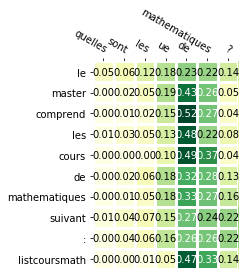

quelles sont les ue de mathematiques ?  - le
quelles sont les ue de mathematiques ?  - master
quelles sont les ue de mathematiques ?  - comprend
quelles sont les ue de mathematiques ?  - les
quelles sont les ue de mathematiques ?  - cours
quelles sont les ue de mathematiques ?  - de
quelles sont les ue de mathematiques ?  - mathematiques
quelles sont les ue de mathematiques ?  - suivant
quelles sont les ue de mathematiques ?  - :
quelles sont les ue de mathematiques ?  - listcoursmath



'le master comprend les cours de mathematiques suivant : listcoursmath'

In [25]:
chatbot.eval()
chatbot('quelles sont les ue de mathématiques ?', attention_method = AttentionViewer)
chatbot('quelles sont les ue de mathématiques ?', attention_method = AttentionViewerOnWords)

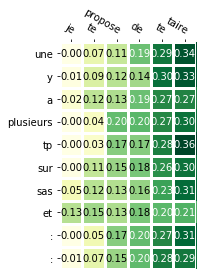

je te propose de te taire  - une
je te propose de te taire  - y
je te propose de te taire  - a
je te propose de te taire  - plusieurs
je te propose de te taire  - tp
je te propose de te taire  - sur
je te propose de te taire  - sas
je te propose de te taire  - et
je te propose de te taire  - :
je te propose de te taire  - :



'une y a plusieurs tp sur sas et : :'

In [24]:
chatbot.eval()
chatbot('je te propose de te taire', attention_method = AttentionViewer)
chatbot('je te propose de te taire', attention_method = AttentionViewerOnWords)